# Mask or Not

---

This small project is an implementation of Machine Learning algorithm to evaluate if a person wears a mask or not from a photo.  
The dataset is composed of circa 1000 photos of people wearing or not a mask ([OneDrive](https://1drv.ms/u/s!Ahpa0I4vvHbvgbcfg_dNA4hwbcz8Bw?e=QUm6P4)).  
Each photo is a portrait of one and only person. There are no photos with more than one person (and if there are, other people are considered as background of the photo and not as part of the main analysis).  
At the end of the project, you can upload a photo and check if the model can recognize or not if you wear a mask.   
Moreover, the project is very GPU dependent so for fast execution of the code you need to activate it in the runtime settings.

In [ ]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
print(np.__version__)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(matplotlib.__version__)

GPU check:

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU not found. Please add a GPU')
else:
    print('Found GPU at: {}'.format(device_name))

## Data preparation

Upload of the compressed dataset in a Colab instance (just below) or skip this block line and import it from Google Drive (it is preferred because the upload from Colab form is very slow)

In [ ]:
#Run this block of code only to upload with Colab. My advice is to skip this block and use Google Drive upload 

import os
from google.colab import files

print("Available files:")
!ls
print()

filename = "MasksDataset.zip"   #If fileneme is different, rename here!
if not os.path.isfile(filename):
    # Upload that file (please)
    uploaded = files.upload()
    print("Uploaded file:")
    for fn in uploaded.keys():
        print("{} {}".format(fn, len(uploaded[fn])))

if os.path.isfile(filename):
    print("SUCCESS!")
else:
    print("FAILURE: file {} was NOT loaded.".format(filename))

If you decide to import from Google Drive, you have to mount the folder.

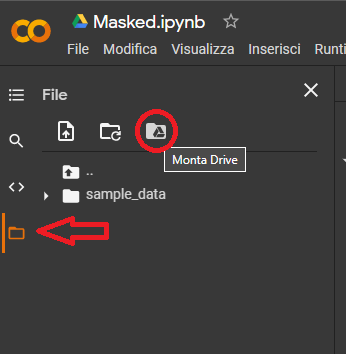


This block copies the file from Google Drive to the `/content` folder of the current runtime




In [ ]:
# Modify the path of the file to load from Google Drive. /content/drive/MyDrive/ is the root folder of Google Drive. Modify the path after this.
# example: /content/drive/MyDrive/Colab Notebooks/MasksDataset.zip

!cp "/content/drive/MyDrive/Colab Notebooks/MasksDataset.zip" "/content"

In [ ]:
!unzip "MasksDataset.zip"

The images of the dataset are in differents format: JPG, JPEG and PNG. Keras read them with no difficulty.

In [ ]:
import pathlib
import PIL
import PIL.Image

data_dir = pathlib.Path('/content/New Masks Dataset')
data_dir
image_count = len(list(data_dir.glob('**/*.jpg'))) + len(list(data_dir.glob('**/*.jpeg'))) + len(list(data_dir.glob('**/*.png')))

print("Total images: " + str(image_count))

We can see two examples of images in `Train/Mask` and `Train/No Mask` dataset. It's important to
remember that each image has its size so it must be resized later.

In [ ]:
maskList = list(data_dir.glob('Train/Mask/*'))
print("Sample Train Mask")
plt.imshow(mpimg.imread(maskList[0]))
plt.axis("off")

In [ ]:
noMaskList = list(data_dir.glob('Train/No Mask/*'))
print("Sample Train No Mask")
plt.imshow(mpimg.imread(noMaskList[0]))
plt.axis("off")

## Dataset creation

In this part we take the photos from the Train dataset and we prepare them as input for Keras.  
First of all we set the image size as 256x256px so every image will have the same dimension. We also set a batch size of 32.  
It has been defined that the 20% of the Training dataset will be used as validation dataset.

In [ ]:
imageSize = (256, 256)
batchSize = 32

trainFolder = pathlib.Path('/content/New Masks Dataset/Train')
testFolder = pathlib.Path('/content/New Masks Dataset/Test')

trainDataset = tf.keras.preprocessing.image_dataset_from_directory(
    trainFolder,
    validation_split = 0.2,
    subset = "training",
    seed = 94070,
    image_size = imageSize,
    batch_size = batchSize
)

validationDataset = tf.keras.preprocessing.image_dataset_from_directory(
    trainFolder,
    validation_split = 0.2,
    subset = "validation",
    seed = 94070,
    image_size = imageSize,
    batch_size = batchSize
)

print('\nNumber of images per batch: {}'.format(batchSize))

After the definition of the training dataset, we define the Test dataset. We will use this after the learning process to verify the reliability of the model.

In [ ]:
testDataset = tf.keras.preprocessing.image_dataset_from_directory(
    testFolder, 
    seed = 1337,
    image_size = imageSize, 
    batch_size = batchSize)

We can see in detail how classes are defined for the train dataset.

In [ ]:
classNames = trainDataset.class_names
print(classNames)

Here there is a preview of the training dataset with the correct class associated

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in trainDataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classNames[labels[i]])
        plt.axis("off")

The block of code below shows us how the training dataset is composed when will be elaborated by the model. There will be a batch of 32 image, each image with width and height of 256 and depth of 3 (corresponding to the RGB set by default during the definition of the datasets). The label tensor will be composed by 32 definitions (0 and 1, 0 for Mask and 1 for No Mask) corresponding to the 32 photos of the batch.

In [ ]:
for image_batch, labels_batch in trainDataset:
    print(image_batch.shape)
    print(labels_batch.shape)
    print("Label tensor example:", labels_batch)
    break

## The model

Now that the dataset is ready, it's time to prepare the model which will first learn and then tell us if a person wear a mask or not "looking" an image.  
The train dataset and the validation dataset are prefetched. This operation guarantee us the maximum velocity of the elaboration. When the model is learning from some data, the system will pre-load the successive data.

In [ ]:
trainDataset = trainDataset.prefetch(buffer_size = 32)
validationDataset = validationDataset.prefetch(buffer_size = 32)

It's time to define the model itself.  
The first thing that the model do is to normalize the data.   
After the normalization, there are several blocks of convolutional 2 dimensions layers and max
pooling. Every convolutional layer has the same padding, activation as RELU, and kernel size
equal to 2 except for the last one with kernel size equal to 4. The main difference between them is the number of filters, that increase for every layer. I also set a dropout of 30% for every epoch.  
At the end of the convolutional blocks, there is a flattening and then a layer of 256 “neurons", with RELU as activation function. As a consequence of the neural network, that should tell us if a person wears a mask or not, the output is composed of 2 elements. After a lot of tests, I noticed that sigmoid is a good activation function for the last layer (Dense 2). Another good activator that I find out for the final layer is the default one (linear).

In [ ]:
from tensorflow.keras import layers

model = tf.keras.Sequential([

    layers.experimental.preprocessing.Rescaling(scale = 1./255, input_shape = (256, 256, 3)),
  
    layers.Conv2D(64, kernel_size = 2, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, kernel_size = 2, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, kernel_size = 2, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(256, kernel_size = 2, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    
    layers.Conv2D(256, kernel_size = 2, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    #
    layers.Conv2D(512, kernel_size = 4, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    
    layers.Flatten(),  
    layers.Dense(256, activation = 'relu'),
    layers.Dense(2, activation="sigmoid")
])

In [ ]:
model.summary()

I decided to use the Adam method as optimizer (stochastic gradient descent), with a learning rate of 0.0001. As loss function I use the Sparse Categorial Cross Entropy, which seems to be better than the Binary Crossentropy, even if there are only 2 possible results.

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False),
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy'])

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)

After some attempts, I decided that 30 is a good number of epochs. With a greater number, it's difficult to foresee better results. In a  relatively small time, the convolutional deep network is trained very well.

In [ ]:
history = model.fit(
    trainDataset,
    validation_data = validationDataset,
    epochs = 30,
    callbacks=[checkpointer]
)

If we evaluate the Test dataset we can see that the accuracy it's pretty good.

In [ ]:
score = model.evaluate(testDataset, verbose=0)
print("Test accuracy: ", score[1])

Here it is showed a small preview of the test dataset. The titles become green if the prediction is
correct and red if it's wrong.

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in testDataset.take(1):
    for i in range(9):
        img_array = tf.keras.preprocessing.image.img_to_array(images[i])
        img_batch = np.expand_dims(img_array, axis=0)
        batch_result = model.predict(img_batch)
        index = np.argmax(batch_result)

        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Correct: " + classNames[labels[i]] + "\nPredicted:" + classNames[index], fontdict={'color' : 'green' if(classNames[labels[i]] == classNames[index]) else 'red'})
        plt.axis("off")

Here there is a plot showing us the trend of accuracy and loss both for training and
validation dataset.

In [ ]:
def plotTrainValAccuracyAndLoss(history, legend_suffix = "", figsize = (8, 6)):

    plt.figure(figsize = figsize)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_' + legend_suffix, 'val_' + legend_suffix], loc = 'lower right')
    plt.show()

    plt.figure(figsize = figsize)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_' + legend_suffix, 'val_' + legend_suffix], loc = 'upper right')
    plt.show()

plotTrainValAccuracyAndLoss(history.history, legend_suffix = 'plot', figsize = (8, 6))

## Do you wear a mask?

This last part of the project gives the possibility to upload an image and let the application recognize if the person in the photo wears a mask or not. I prepared two different ways to evaluate a personal photo: the first one by uploading it on the runtime space and the second one using the webcam.    

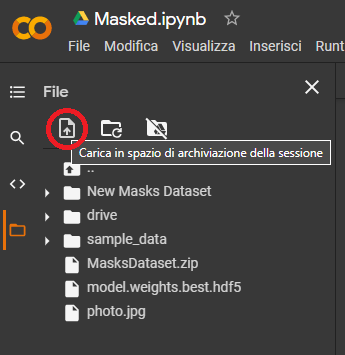  


In [ ]:
#Run this block of code to evaluate an uploaded image 

#Modify the path and the name of the uploaded image
myImage = pathlib.Path('/content/photo.jpg')


img = tf.keras.preprocessing.image.load_img(myImage, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

index = np.argmax(model.predict(img_batch))
print("Evaluation: " + classNames[index])

plt.imshow(mpimg.imread(myImage))
plt.axis("off")

The code blocks below allows you to take a photo directly from the webcam and immediately evaluate it. The first one initializes the webcam. The second one is used for taking the
photo.

In [ ]:
#Run this code to caputre images from webcam

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

In [ ]:
from IPython.display import Image
try:
    filename = take_photo()
    print('Saved to {}'.format(filename))

    webcamImage = pathlib.Path('/content/photo.jpg')

    img = tf.keras.preprocessing.image.load_img(webcamImage, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    pred_values = model.predict(img_batch)
    index = np.argmax(pred_values)
    print("\nEvaluation: " + classNames[index] + "\n")
    print("Values: " + str(pred_values) + "\n")

    display(Image(filename))


except Exception as err:
    print(str(err))